In [1]:
%matplotlib ipympl

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation
from matplotlib.patches import FancyArrowPatch
from scipy.spatial.transform import Rotation
from tsfresh import feature_extraction

from drift_ml.datasets.bosch_cnc_machining.utils.dataloader import NPYBoschCNCDataLoader
from drift_ml.datasets.bosch_cnc_machining.utils.utils import (
    augment_xyz_samples,
    extract_tsfresh_features,
)

In [3]:
loader = NPYBoschCNCDataLoader(
    metadata_path="/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/metadata_ws4096.pkl"
)
loader.load_data(
    "/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_x_raw_ws4096.npy",
    "/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_y_raw_ws4096.npy",
)


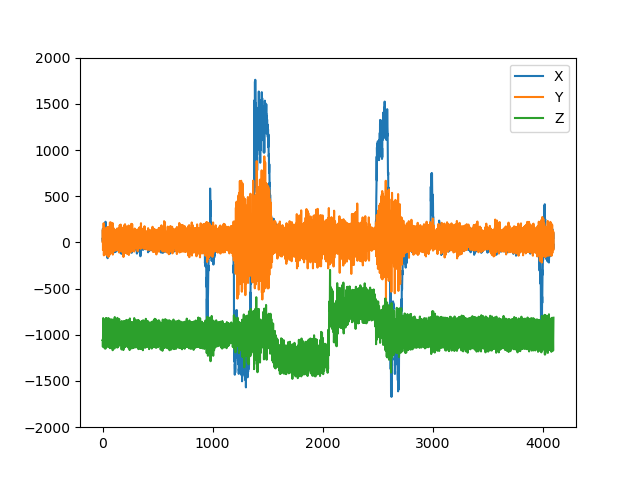

In [8]:
index = 100

fig, ax = plt.subplots()
ax.plot(loader.sample_data_X[index])


ax.clear()
augmented_samples = augment_xyz_samples(loader.sample_data_X[index], pitch_deg=0)
ax.plot(augmented_samples)
plt.gca().set_ylim([-2000, 2000])
plt.gca().legend(['X', 'Y', 'Z'])

Plot signals

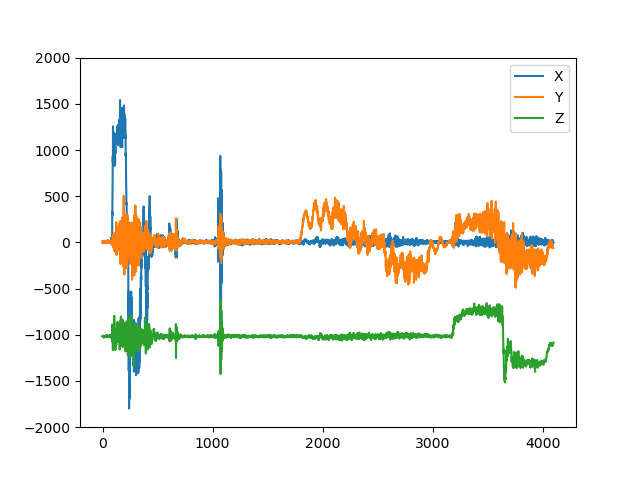

In [4]:
index = 0

fig, ax = plt.subplots()
ax.plot(loader.sample_data_X[index])


def animate(frame_num):
    ax.clear()
    augmented_samples = augment_xyz_samples(loader.sample_data_X[index], roll_deg=frame_num, yaw_deg=frame_num, pitch_deg=frame_num)
    ax.plot(augmented_samples)
    plt.gca().set_ylim([-2000, 2000])
    plt.gca().legend(['X', 'Y', 'Z'])

anim = animation.FuncAnimation(fig, animate, frames=360, interval=5, repeat=True)
# plt.show()
anim.save("/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/notebooks/test.gif", writer=animation.PillowWriter(fps=30))

Plot coordinate system

stolen from https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c

In [3]:
class Annotation3D(Annotation):
    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)

def _annotate3D(ax, text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D, 'annotate3D', _annotate3D)

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs) 

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)

setattr(Axes3D, 'arrow3D', _arrow3D)

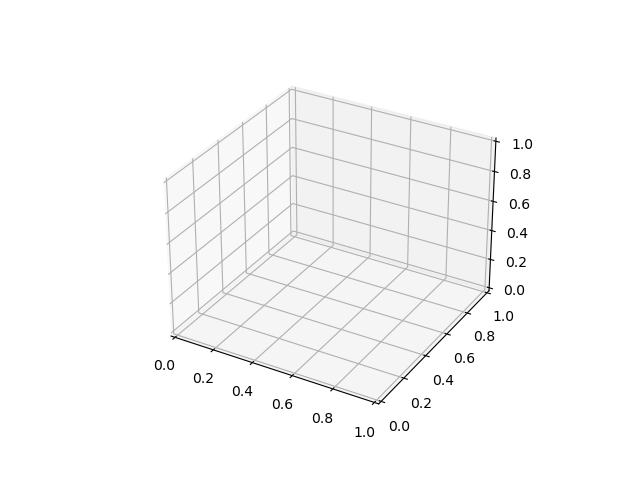

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


def animate(frame_num):
    ax.clear()
    center = np.array([1.0, 1.0, 1.0])
    x = np.array([0.5, 0.0, 0.0])
    y = np.array([0.0, 0.5, 0.0])
    z = np.array([0.0, 0.0, 0.5])

    rot_matrix = Rotation.from_euler(
        "zyx", [frame_num, 0.0, 0.0], degrees=True
    ).as_matrix()
    x_rotated = rot_matrix @ x
    y_rotated = rot_matrix @ y
    z_rotated = rot_matrix @ z

    ax.annotate3D('X`', center+x_rotated, xytext=(3, 3), textcoords='offset points')
    ax.annotate3D('Y`', center+y_rotated, xytext=(3, 3), textcoords='offset points')
    ax.annotate3D('Z`', center+z_rotated, xytext=(3, 3), textcoords='offset points')
    ax.arrow3D(*center,
            *x_rotated,
            mutation_scale=20,
            arrowstyle="-|>",
            linestyle='dashed')
    ax.arrow3D(*center,
            *y_rotated,
            mutation_scale=20,
            arrowstyle="-|>",
            linestyle='dashed')
    ax.arrow3D(*center,
            *z_rotated,
            mutation_scale=20,
            arrowstyle="-|>",
            linestyle='dashed')
    ax.set_title('Sensor coordinate system')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([0, 2])
    ax.set_ylim([0, 2])
    ax.set_zlim([0, 2])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

anim = animation.FuncAnimation(fig, animate, frames=360, interval=5, repeat=True)
plt.show()

In [5]:
anim.save("/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/notebooks/coordinates.gif", writer=animation.PillowWriter(fps=30))